In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import time
import random
import math
import tensorflow as tf
%matplotlib inline

from skmultiflow.drift_detection import PageHinkley, ADWIN
from skmultiflow.data import DataStream
from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from tensorflow.keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.utils.np_utils import to_categorical
from keras.utils import to_categorical
from scipy.stats import spearmanr
from scipy.stats import entropy
from tensorflow import keras
from skmultiflow.drift_detection import ADWIN

In [2]:
def get_initial_model(inp, out): #get initial model
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(out, activation='softmax')
        ])
    #optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [3]:
def get_initial_model_2(inp, out):
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(20, activation='relu'),
        Dense(10, activation='relu'),
        Dense(out, activation='softmax')
        ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [4]:
def DP_get_initial_model(inp, out): #get initial model
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(out, activation='softmax')
        ])
    #optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [5]:
def DP_get_initial_model_2(inp, out): #get initial model
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(20, activation='relu'),
        Dense(10, activation='relu'),
        Dense(out, activation='softmax')
        ])
    #optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
def node_comparison1(node1, node2, epsilon=0.05): #this function is to see if the nodes are atmost epsilon distance apart
  for x, y in zip(node1,node2):
    #print(x,y)
    if isinstance(x, list):
        if((np.linalg.norm(np.array(x)-np.array(y))/len(x))<=epsilon):
            continue
        else:
            return False
    else:
        if(math.sqrt((x-y)*(x-y))<=epsilon):
            continue
        else:
            return False
  return True

In [7]:
def node_comparison(node1, node2):
  for x, y in zip(node1,node2):
    #print(x,y)
    if isinstance(x, list):
        if(sorted(x)==sorted(y)):
            continue
        else:
            return False
    else:
        if(x==y):
            continue
        else:
            return False
  return True

In [8]:
def layer_comparison(layer1, layer2): #compare same layers in two different DNNs
  for node1 in layer1:
    present=False
    for node2 in layer2:
      if (node_comparison1(node1, node2)):
        present=True
    if present==False:
      return False
  return True

In [9]:
def check_models(Model_weights1, Model_weights2): # compare two deep neural networks based on their weights
  for i in range(0,len(Model_weights1), 2):
    layer1=[]
    layer2=[]
    for j in range(len(Model_weights1[i+1].T)):
      Node1=[]
      Node2=[]
      Node1.append(list(Model_weights1[i].T[j]))
      Node1.append(Model_weights1[i+1][j])
      if (i+2<len(Model_weights1)):
        Node1.append(list(Model_weights1[i+2][j]))
      Node2.append(list(Model_weights2[i].T[j]))
      Node2.append(Model_weights2[i+1][j])
      if (i+2<len(Model_weights2)):
        Node2.append(list(Model_weights2[i+2][j]))
      layer1.append(Node1)
      layer2.append(Node2)
    if (layer_comparison(layer1, layer2)):
      continue
    else:
      return False
  return True

In [10]:
#this function is used to average out all the models in the epsilon range
#the problem is different here than compared with model comparison. Shape not important.
def get_avg_weights(models_weights, inp_shape, out_shape):
    avg_sum=get_initial_model(inp_shape, out_shape).get_weights()
    #print(avg_sum)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                for k in range(len(avg_sum[i][j])):
                    avg_sum[i][j][k]=0
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=0
    #print(avg_sum)
    print(models_weights[0])
    for i in range(len(models_weights)):
        for j in range(0, len(avg_sum),2):
            #print(isinstance(avg_sum[j], np.ndarray))
            #if(isinstance(avg_sum[j][0], np.ndarray)):
            for k in range(len(avg_sum[j])):
                avg_sum[j][k]=[avg_sum[j][k][l]+models_weights[i][j][k][l] for l in range(len(avg_sum[j][k]))]
            #print(isinstance(avg_sum[j], np.ndarray))
            #else: gayab kr diya
            for k in range(len(avg_sum[j+1])):
                avg_sum[j+1][k]=avg_sum[j+1][k]+models_weights[i][j+1][k]
    print("yhn tk")
    mean_size=len(models_weights)
    print(mean_size)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                #print("yhn tk")
                avg_sum[i][j]=[avg_sum[i][j][k]/mean_size for k in range(len(avg_sum[i][j]))]
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=avg_sum[i+1][j]/mean_size
    print("Done")
    return avg_sum

In [11]:
#this function is used to average out all the models in the epsilon range
#the problem is different here than compared with model comparison. Shape not important.
def get_avg_weights_2(models_weights, inp_shape, out_shape):
    avg_sum=get_initial_model_2(inp_shape, out_shape).get_weights()
    #print(avg_sum)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                for k in range(len(avg_sum[i][j])):
                    avg_sum[i][j][k]=0
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=0
    #print(avg_sum)
    print(models_weights[0])
    for i in range(len(models_weights)):
        for j in range(0, len(avg_sum),2):
            #print(isinstance(avg_sum[j], np.ndarray))
            #if(isinstance(avg_sum[j][0], np.ndarray)):
            for k in range(len(avg_sum[j])):
                avg_sum[j][k]=[avg_sum[j][k][l]+models_weights[i][j][k][l] for l in range(len(avg_sum[j][k]))]
            #print(isinstance(avg_sum[j], np.ndarray))
            #else: gayab kr diya
            for k in range(len(avg_sum[j+1])):
                avg_sum[j+1][k]=avg_sum[j+1][k]+models_weights[i][j+1][k]
    print("yhn tk")
    mean_size=len(models_weights)
    print(mean_size)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                #print("yhn tk")
                avg_sum[i][j]=[avg_sum[i][j][k]/mean_size for k in range(len(avg_sum[i][j]))]
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=avg_sum[i+1][j]/mean_size
    print("Done")
    return avg_sum

In [12]:
# custom functions for f1, precision and recall

from keras import backend as K
from keras.utils import to_categorical
from sklearn import preprocessing

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [13]:
# A function to check if the two samples are different:
def return_samples(Positive, Negative, data, N):
    datasets=[]
    positiveN=int((Positive.shape[0]/data.shape[0])*N)
    negativeN=int(N-positiveN)
    print(negativeN)
    while (Positive.empty==False and Negative.empty==False):
        df1=Positive.sample(min(positiveN, len(Positive)))
        Positive.drop(df1.index, inplace=True)
        """
        drop_df1=np.random.choice(df1.index,(int)(min(positiveN, math.ceil(len(Positive))/2)), replace=False)
        if len(Positive)<positiveN:
            Positive.drop(df1.index, inplace=True)
        else:
            Positive.drop(drop_df1, inplace=True)
        #print(len(Positive))
        """
        df2=Negative.sample(min(negativeN, len(Negative)))
        Negative.drop(df2.index, inplace=True)
        """
        drop_df2 = np.random.choice(df2.index,(int)(min(negativeN, math.ceil(len(Negative))/2)))
        if len(Negative)<negativeN:
            Negative.drop(df2.index, inplace = True)
        else:
            Negative.drop(drop_df2, inplace=True)
        """
        dataset=df1.append(df2, ignore_index=True)
        dataset.sample(frac = 1)
        dataset.sample(frac = 1)
        dataset.sample(frac = 1)
        datasets.append(dataset)
    print("returned datasets")
    return datasets

In [14]:
#generate sampele which are plausible deniable
#there exists a data lets say data
def generate_samples(data, num_samples, N):
    samples=[]
    intersection=[]
    while num_samples>0:    
        Positive = data[data[target_variable]==0]
        Negative = data[data[target_variable]==1]
        positiveN=int((Positive.shape[0]/data.shape[0])*N)
        negativeN=int(N-positiveN)
        df1=Positive.sample(positiveN)
        #Positive.drop(df1.index, inplace=True)
        df2=Negative.sample(negativeN)
        #Negative.drop(df2.index, inplace=True)
        sample=df1.append(df2, ignore_index=False)
        samples.append(sample)
        num_samples-=1

    intersection=list(set(samples[0].index).intersection(samples[1].index))
    for i in range(2,len(samples)):
        intersection=list(set(samples[i].index).intersection(intersection))
    if intersection:
        rnum = random.randint(0, len(samples)-1)
        samples[rnum].drop(intersection)
        print("some intersection")
    print("finished")
    return samples

In [15]:
#do we need to find all the models or only the mean recommended models?
def epsilon_mean_recommendation(add_weights,data):
    mean_model_weights=[]
    for i in range(len(add_weights)):
        mean_model_weights.append(get_avg_weights(add_weights[i],data.shape[1]-1, 2))
    mean_models=[]
    mean_model_train_metrics=[]
    mean_model_loss=[]
    mean_model_acc=[]
    mean_model_test_metrics=[]
    mean_model_test_loss=[]
    mean_model_test_acc=[]
    y = to_categorical(data[target_variable])
    X = data.drop(columns=target_variable)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    for i in range(len(add_weights)):
        init_model=get_initial_model(X_test.shape[1], 2)
        init_model.set_weights(mean_model_weights[i])
        mean_model_train_metrics.append(init_model.evaluate(X_train, y_train))
        mean_model_loss.append(mean_model_train_metrics[i][0])
        mean_model_acc.append(mean_model_train_metrics[i][1])
        mean_model_test_metrics.append(init_model.evaluate(X_test, y_test))
        mean_model_test_loss.append(mean_model_test_metrics[i][0])
        mean_model_test_acc.append(mean_model_test_metrics[i][1])
    return mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss

In [16]:
#do we need to find all the models or only the mean recommended models?
def epsilon_mean_recommendation_2(add_weights,data):
    mean_model_weights=[]
    for i in range(len(add_weights)):
        mean_model_weights.append(get_avg_weights_2(add_weights[i],data.shape[1]-1, 2))
    mean_models=[]
    mean_model_train_metrics=[]
    mean_model_loss=[]
    mean_model_acc=[]
    mean_model_test_metrics=[]
    mean_model_test_loss=[]
    mean_model_test_acc=[]
    y = to_categorical(data[target_variable])
    X = data.drop(columns=target_variable)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    for i in range(len(add_weights)):
        init_model=get_initial_model_2(X_test.shape[1], 2)
        init_model.set_weights(mean_model_weights[i])
        mean_model_train_metrics.append(init_model.evaluate(X_train, y_train))
        mean_model_loss.append(mean_model_train_metrics[i][0])
        mean_model_acc.append(mean_model_train_metrics[i][1])
        mean_model_test_metrics.append(init_model.evaluate(X_test, y_test))
        mean_model_test_loss.append(mean_model_test_metrics[i][0])
        mean_model_test_acc.append(mean_model_test_metrics[i][1])
    return mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss

In [17]:
def drift_detection(models, incoming_data):
    predictions = []
    prediction_probe=[]
    
    
    y_test=to_categorical(incoming_data[target_variable])
    #print(y_test)
    X_test=incoming_data.drop(columns=target_variable)
    
    init_model=get_initial_model(incoming_data.shape[1]-1, 2)
    
    for i in range(len(models)):
        init_model.set_weights(models[i])
        predictions.append(init_model.predict(X_test))
    prediction_probe = np.mean(predictions, axis = 0)
    entro = entropy(prediction_probe, base=2, axis=1)
    
    entropy_list = entro.tolist()
    
    return prediction_probe, entropy_list

In [18]:
def drift_detection_2(models, incoming_data):
    predictions = []
    prediction_probe=[]
    
    
    y_test=to_categorical(incoming_data[target_variable])
    #print(y_test)
    X_test=incoming_data.drop(columns=target_variable)
    
    init_model=get_initial_model_2(incoming_data.shape[1]-1, 2)
    
    for i in range(len(models)):
        init_model.set_weights(models[i])
        predictions.append(init_model.predict(X_test))
    prediction_probe = np.mean(predictions, axis = 0)
    entro = entropy(prediction_probe, base=2, axis=1)
    
    entropy_list = entro.tolist()
    
    return prediction_probe, entropy_list

In [19]:
def update_train_data(train_data, incoming_data):
    train_data.drop(index=train_data.index[:len(incoming_data)], inplace=True)
    train_data=train_data.append(incoming_data, ignore_index=True)
    return train_data

In [59]:
data = pd.read_csv("sin_classification_large_drift.csv")
from skmultiflow.data import DataStream

stream = DataStream(data)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.1))
print(len(initial_data[1]))
data_init=pd.DataFrame(initial_data[0], columns=data.columns[:-1])
target_variable = 'y'
data_init['y']=initial_data[1]
print(data_init)

target_variable='y'

N = int(data_init.shape[0]*0.25)

samples = generate_samples(data_init, 100, N)
initial_model= get_initial_model(data.shape[1]-1, 2)

20000
             x1        x2        x3        x4  y
0      0.900395  0.284435  0.308094  0.242561  0
1      0.078758  0.030236  0.047542  0.638051  0
2      0.954808  0.348666  0.934022  0.770769  0
3      0.462751  0.012494  0.782287  0.705243  0
4      0.692544  0.322162  0.614659  0.670095  0
...         ...       ...       ...       ... ..
19995  0.335412  0.241783  0.755269  0.465764  0
19996  0.623528  0.464222  0.062435  0.462664  0
19997  0.380068  0.813165  0.175575  0.930339  1
19998  0.175327  0.258326  0.658530  0.256465  1
19999  0.614989  0.069757  0.331914  0.579301  0

[20000 rows x 5 columns]
finished


In [60]:
#get details of models in the epsilon integrally private range
epsilon = 0.00001
#A function to return integrally private model weights with the number of recurrence
#def get_IP_models(data, epsilon=0.01, target=2):

"""
df1=Positive.sample(positiveN)
Positive.drop(df1.index, inplace=True)
df2=Negative.sample(negativeN)
Negative.drop(df2.index, inplace=True)
test_data=df1.append(df2, ignore_index=True)
test_data=test_data.sample(frac = 1) #This is to shuffel the training and testing data
test_data=test_data.sample(frac = 1)
test_data=test_data.sample(frac = 1)
X_test=test_data.drop(columns=[target_variable])
y_test=to_categorical(test_data[target_variable])
"""

# adding dense layer
Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]
while ind<len(samples):
  """"
  print(positiveN, negativeN)
  df1=Positive.sample(min(positiveN, len(Positive)))
  Positive.drop(df1.index, inplace=True)
  df2=Negative.sample(min(negativeN, len(Negative)))
  Negative.drop(df2.index, inplace=True)
  train_data=df1.append(df2, ignore_index=True)
  train_data=train_data.sample(frac = 1) #shuffel test data 3 times
  train_data=train_data.sample(frac = 1) #shuffel test data 3 times
  train_data=train_data.sample(frac = 1) #shuffel test data 3 times

  #all models have different initialization
  # define the sequential model
  """
  train_data=samples[ind]
  ind=ind+1
  """initial_model = keras.Sequential()

    # adding dense layer
  initial_model.add(Dense(5, input_dim=X_test.shape[1], kernel_initializer='normal', activation='relu'))
  initial_model.add(Dense(10, activation='relu'))
  initial_model.add(Dense(5, activation='relu'))

    # adding dense layer with softmax activation/output layer
  initial_model.add(Dense(2, activation='softmax'))
  #initial_model.summary()"""
  ann_model=get_initial_model(data.shape[1]-1, 2) #same intial weights
  ann_model.set_weights(initial_model.get_weights())
  X_train=train_data.drop(columns=[target_variable])
  #train_data[target_variable]=train_data[target_variable]-1 #only for skin_nonskin dataset
  y_train=to_categorical(train_data[target_variable])
  #print(y_train)
  ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m]) # metrics=['accuracy']
  history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
  print(history.history['f1_m'][-1])
  #ann_model.set_weights(update_weights(ann_model.get_weights()))
  #pred_test=ann_model.predict(X_test)
  present=False
  for i in range(len(Models)):
    if (check_models(Models[i][0], ann_model.get_weights())):
      print("if any")
      Models[i][1]=Models[i][1]+1
      add_weights[i].append(ann_model.get_weights())
      val_acc[i].append(history.history['val_f1_m'])
      train_acc[i].append(history.history['f1_m'])
      #test_acc[i].append(f1_m(y_test, pred_test).numpy())
      val_loss[i].append(history.history['val_loss'])
      train_loss[i].append(history.history['loss'])
      present=True
      break;
  if present==False:
    add_weights.append([ann_model.get_weights()])
    Models.append([ann_model.get_weights(), 1])
    val_acc.append([history.history['val_f1_m']])
    train_acc.append([history.history['f1_m']])
    #test_acc.append([f1_m(y_test, pred_test).numpy()])
    val_loss.append([history.history['val_loss']])
    train_loss.append([history.history['loss']])
add_weights, Models, val_acc, train_acc, train_loss, val_acc, val_loss = add_weights, Models, val_acc, train_acc, train_loss, val_acc, val_loss

#add_weights, Models, val_acc, train_acc, train_loss, val_acc, val_loss = get_IP_models(data_init, epsilon=0.001, target=2)
#Models

Epoch 1/10
125/125 [==============================] - 0s 1ms/step - loss: 0.6506 - f1_m: 0.6930 - val_loss: 0.7203 - val_f1_m: 0.3379
Epoch 2/10
125/125 [==============================] - 0s 838us/step - loss: 0.5476 - f1_m: 0.8152 - val_loss: 0.5696 - val_f1_m: 0.7695
Epoch 3/10
125/125 [==============================] - 0s 834us/step - loss: 0.4276 - f1_m: 0.9205 - val_loss: 0.4613 - val_f1_m: 0.8252
Epoch 4/10
125/125 [==============================] - 0s 884us/step - loss: 0.3234 - f1_m: 0.9470 - val_loss: 0.3142 - val_f1_m: 0.9424
Epoch 5/10
125/125 [==============================] - 0s 827us/step - loss: 0.2530 - f1_m: 0.9643 - val_loss: 0.2618 - val_f1_m: 0.9463
Epoch 6/10
125/125 [==============================] - 0s 813us/step - loss: 0.2087 - f1_m: 0.9697 - val_loss: 0.2372 - val_f1_m: 0.9375
Epoch 7/10
125/125 [==============================] - 0s 812us/step - loss: 0.1795 - f1_m: 0.9740 - val_loss: 0.1857 - val_f1_m: 0.9688
Epoch 8/10
125/125 [==============================

125/125 [==============================] - 0s 802us/step - loss: 0.1592 - f1_m: 0.9765 - val_loss: 0.1695 - val_f1_m: 0.9629
Epoch 10/10
125/125 [==============================] - 0s 791us/step - loss: 0.1456 - f1_m: 0.9800 - val_loss: 0.1582 - val_f1_m: 0.9639
0.9800000190734863
if any
Epoch 1/10
125/125 [==============================] - 0s 1ms/step - loss: 0.6507 - f1_m: 0.7087 - val_loss: 0.7400 - val_f1_m: 0.2656
Epoch 2/10
125/125 [==============================] - 0s 811us/step - loss: 0.5411 - f1_m: 0.8280 - val_loss: 0.5371 - val_f1_m: 0.8037
Epoch 3/10
125/125 [==============================] - 0s 802us/step - loss: 0.4163 - f1_m: 0.9262 - val_loss: 0.4242 - val_f1_m: 0.8691
Epoch 4/10
125/125 [==============================] - 0s 791us/step - loss: 0.3211 - f1_m: 0.9510 - val_loss: 0.3395 - val_f1_m: 0.8955
Epoch 5/10
125/125 [==============================] - 0s 781us/step - loss: 0.2582 - f1_m: 0.9600 - val_loss: 0.2535 - val_f1_m: 0.9561
Epoch 6/10
125/125 [==============

125/125 [==============================] - 0s 807us/step - loss: 0.1855 - f1_m: 0.9762 - val_loss: 0.2014 - val_f1_m: 0.9590
Epoch 8/10
125/125 [==============================] - 0s 798us/step - loss: 0.1646 - f1_m: 0.9800 - val_loss: 0.2004 - val_f1_m: 0.9453
Epoch 9/10
125/125 [==============================] - 0s 802us/step - loss: 0.1489 - f1_m: 0.9812 - val_loss: 0.1828 - val_f1_m: 0.9492
Epoch 10/10
125/125 [==============================] - 0s 796us/step - loss: 0.1361 - f1_m: 0.9825 - val_loss: 0.1656 - val_f1_m: 0.9551
0.9825000166893005
if any
Epoch 1/10
125/125 [==============================] - 0s 1ms/step - loss: 0.6525 - f1_m: 0.6667 - val_loss: 0.7210 - val_f1_m: 0.3184
Epoch 2/10
125/125 [==============================] - 0s 818us/step - loss: 0.5517 - f1_m: 0.8162 - val_loss: 0.5784 - val_f1_m: 0.7520
Epoch 3/10
125/125 [==============================] - 0s 826us/step - loss: 0.4338 - f1_m: 0.9093 - val_loss: 0.4594 - val_f1_m: 0.8398
Epoch 4/10
125/125 [==============

125/125 [==============================] - 0s 809us/step - loss: 0.2687 - f1_m: 0.9600 - val_loss: 0.2909 - val_f1_m: 0.9326
Epoch 6/10
125/125 [==============================] - 0s 811us/step - loss: 0.2247 - f1_m: 0.9675 - val_loss: 0.2757 - val_f1_m: 0.9121
Epoch 7/10
125/125 [==============================] - 0s 794us/step - loss: 0.1936 - f1_m: 0.9740 - val_loss: 0.2348 - val_f1_m: 0.9326
Epoch 8/10
125/125 [==============================] - 0s 799us/step - loss: 0.1711 - f1_m: 0.9765 - val_loss: 0.2134 - val_f1_m: 0.9395
Epoch 9/10
125/125 [==============================] - 0s 798us/step - loss: 0.1536 - f1_m: 0.9785 - val_loss: 0.1879 - val_f1_m: 0.9512
Epoch 10/10
125/125 [==============================] - 0s 794us/step - loss: 0.1404 - f1_m: 0.9800 - val_loss: 0.1774 - val_f1_m: 0.9492
0.9800000190734863
if any
Epoch 1/10
125/125 [==============================] - 0s 1ms/step - loss: 0.6573 - f1_m: 0.6412 - val_loss: 0.7114 - val_f1_m: 0.3818
Epoch 2/10
125/125 [==============

125/125 [==============================] - 0s 822us/step - loss: 0.4115 - f1_m: 0.9247 - val_loss: 0.4389 - val_f1_m: 0.8398
Epoch 4/10
125/125 [==============================] - 0s 812us/step - loss: 0.3149 - f1_m: 0.9485 - val_loss: 0.3268 - val_f1_m: 0.9248
Epoch 5/10
125/125 [==============================] - 0s 789us/step - loss: 0.2538 - f1_m: 0.9603 - val_loss: 0.2772 - val_f1_m: 0.9346
Epoch 6/10
125/125 [==============================] - 0s 794us/step - loss: 0.2134 - f1_m: 0.9710 - val_loss: 0.2339 - val_f1_m: 0.9502
Epoch 7/10
125/125 [==============================] - 0s 802us/step - loss: 0.1853 - f1_m: 0.9712 - val_loss: 0.1945 - val_f1_m: 0.9648
Epoch 8/10
125/125 [==============================] - 0s 785us/step - loss: 0.1640 - f1_m: 0.9745 - val_loss: 0.2039 - val_f1_m: 0.9404
Epoch 9/10
125/125 [==============================] - 0s 807us/step - loss: 0.1484 - f1_m: 0.9775 - val_loss: 0.1862 - val_f1_m: 0.9482
Epoch 10/10
125/125 [==============================] - 0s 8

125/125 [==============================] - 0s 1ms/step - loss: 0.6507 - f1_m: 0.6730 - val_loss: 0.7226 - val_f1_m: 0.3213
Epoch 2/10
125/125 [==============================] - 0s 823us/step - loss: 0.5464 - f1_m: 0.8212 - val_loss: 0.5677 - val_f1_m: 0.7568
Epoch 3/10
125/125 [==============================] - 0s 815us/step - loss: 0.4260 - f1_m: 0.9110 - val_loss: 0.4470 - val_f1_m: 0.8496
Epoch 4/10
125/125 [==============================] - 0s 797us/step - loss: 0.3305 - f1_m: 0.9482 - val_loss: 0.3906 - val_f1_m: 0.8369
Epoch 5/10
125/125 [==============================] - 0s 789us/step - loss: 0.2672 - f1_m: 0.9570 - val_loss: 0.2871 - val_f1_m: 0.9248
Epoch 6/10
125/125 [==============================] - 0s 802us/step - loss: 0.2243 - f1_m: 0.9675 - val_loss: 0.2235 - val_f1_m: 0.9590
Epoch 7/10
125/125 [==============================] - 0s 796us/step - loss: 0.1952 - f1_m: 0.9743 - val_loss: 0.2230 - val_f1_m: 0.9375
Epoch 8/10
125/125 [==============================] - 0s 800u

125/125 [==============================] - 0s 814us/step - loss: 0.1542 - f1_m: 0.9765 - val_loss: 0.1777 - val_f1_m: 0.9697
Epoch 10/10
125/125 [==============================] - 0s 797us/step - loss: 0.1407 - f1_m: 0.9793 - val_loss: 0.1780 - val_f1_m: 0.9570
0.9792500138282776
if any
Epoch 1/10
125/125 [==============================] - 0s 1ms/step - loss: 0.6508 - f1_m: 0.6650 - val_loss: 0.7119 - val_f1_m: 0.3721
Epoch 2/10
125/125 [==============================] - 0s 820us/step - loss: 0.5367 - f1_m: 0.8410 - val_loss: 0.5099 - val_f1_m: 0.8652
Epoch 3/10
125/125 [==============================] - 0s 818us/step - loss: 0.4064 - f1_m: 0.9335 - val_loss: 0.4089 - val_f1_m: 0.8711
Epoch 4/10
125/125 [==============================] - 0s 811us/step - loss: 0.3099 - f1_m: 0.9570 - val_loss: 0.3149 - val_f1_m: 0.9180
Epoch 5/10
125/125 [==============================] - 0s 796us/step - loss: 0.2491 - f1_m: 0.9680 - val_loss: 0.2517 - val_f1_m: 0.9434
Epoch 6/10
125/125 [==============

125/125 [==============================] - 0s 803us/step - loss: 0.1784 - f1_m: 0.9768 - val_loss: 0.1873 - val_f1_m: 0.9600
Epoch 8/10
125/125 [==============================] - 0s 799us/step - loss: 0.1585 - f1_m: 0.9797 - val_loss: 0.1929 - val_f1_m: 0.9326
Epoch 9/10
125/125 [==============================] - 0s 784us/step - loss: 0.1430 - f1_m: 0.9810 - val_loss: 0.1690 - val_f1_m: 0.9463
Epoch 10/10
125/125 [==============================] - 0s 783us/step - loss: 0.1308 - f1_m: 0.9820 - val_loss: 0.1515 - val_f1_m: 0.9639
0.9819999933242798
if any
Epoch 1/10
125/125 [==============================] - 0s 1ms/step - loss: 0.6515 - f1_m: 0.6910 - val_loss: 0.7048 - val_f1_m: 0.4092
Epoch 2/10
125/125 [==============================] - 0s 808us/step - loss: 0.5406 - f1_m: 0.8380 - val_loss: 0.5393 - val_f1_m: 0.8203
Epoch 3/10
125/125 [==============================] - 0s 805us/step - loss: 0.4133 - f1_m: 0.9315 - val_loss: 0.4216 - val_f1_m: 0.8662
Epoch 4/10
125/125 [==============

125/125 [==============================] - 0s 811us/step - loss: 0.2484 - f1_m: 0.9663 - val_loss: 0.2715 - val_f1_m: 0.9150
Epoch 6/10
125/125 [==============================] - 0s 802us/step - loss: 0.2071 - f1_m: 0.9690 - val_loss: 0.2352 - val_f1_m: 0.9209
Epoch 7/10
125/125 [==============================] - 0s 795us/step - loss: 0.1788 - f1_m: 0.9747 - val_loss: 0.1766 - val_f1_m: 0.9639
Epoch 8/10
125/125 [==============================] - 0s 795us/step - loss: 0.1590 - f1_m: 0.9780 - val_loss: 0.1887 - val_f1_m: 0.9297
Epoch 9/10
125/125 [==============================] - 0s 790us/step - loss: 0.1435 - f1_m: 0.9803 - val_loss: 0.1516 - val_f1_m: 0.9619
Epoch 10/10
125/125 [==============================] - 0s 792us/step - loss: 0.1313 - f1_m: 0.9827 - val_loss: 0.1667 - val_f1_m: 0.9346
0.9827499985694885
if any
Epoch 1/10
125/125 [==============================] - 0s 1ms/step - loss: 0.6515 - f1_m: 0.6810 - val_loss: 0.7076 - val_f1_m: 0.3994
Epoch 2/10
125/125 [==============

In [ ]:
len(Models)

#here use only top 5-10 integrally private models.
#add_weights=add_weights[top_5]
A=np.argsort(np.array(Models).T[1])[::-1][:5]
print(np.array(Models).T[1])
print(A)
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])
#add_weights=add_weights[A]


# Now trying to generate Streaming settings for the dataset
# lets find the outputs from all the 
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data)


In [ ]:
#right now trying for mean models
stream_mean_results=[]
current_window = data_init.copy()
delta=0.01
adwin = ADWIN(delta)
detected = False
retraining_count=0
data_window=data_init.copy()
target_variable = 'y'
num_models=[]
Models_len=[]
stream.restart()
y_pred_total = []
y_pred_uncertainty_total = []
true_values = []
while stream.n_remaining_samples()>1:
    incoming_data = stream.next_sample(five_percent)
    #rint(incoming_data)
    data_incoming = pd.DataFrame(incoming_data[0], columns=data.columns[:-1])
    data_incoming[target_variable]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    #print(data_incoming)
    y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_incoming.copy()) 
    #detected, evaluate, adwin = drift_detection_each_model(mean_model_weights, data_incoming.copy(), adwin)
    y_pred_total.append(y_pred)
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print(len(y_pred_uncertainty))
    for i in range(len(y_pred_uncertainty)):
        adwin.add_element(y_pred_uncertainty[i])
        if adwin.detected_change():
            detected = True
            break;
    if detected:
        print("drift has been detecte models must be retrained")
        data_window = update_train_data(data_window, data_incoming)
        
        retraining_count+=1
        N = int(data_window.shape[0]*0.25)

        samples = generate_samples(data_window, 100, N)
        """
        df1=Positive.sample(positiveN)
        Positive.drop(df1.index, inplace=True)
        df2=Negative.sample(negativeN)
        Negative.drop(df2.index, inplace=True)
        test_data=df1.append(df2, ignore_index=True)
        test_data=test_data.sample(frac = 1) #This is to shuffel the training and testing data
        test_data=test_data.sample(frac = 1)
        test_data=test_data.sample(frac = 1)
        X_test=test_data.drop(columns=[target_variable])
        y_test=to_categorical(test_data[target_variable])
        """

        # adding dense layer
        initial_model= get_initial_model(data.shape[1]-1, 2)
        Models=[]
        val_acc=[]
        train_acc=[]
        test_acc=[]
        val_loss=[]
        train_loss=[]
        ind=0
        add_weights=[]
        while ind<len(samples):
          """"
          print(positiveN, negativeN)
          df1=Positive.sample(min(positiveN, len(Positive)))
          Positive.drop(df1.index, inplace=True)
          df2=Negative.sample(min(negativeN, len(Negative)))
          Negative.drop(df2.index, inplace=True)
          train_data=df1.append(df2, ignore_index=True)
          train_data=train_data.sample(frac = 1) #shuffel test data 3 times
          train_data=train_data.sample(frac = 1) #shuffel test data 3 times
          train_data=train_data.sample(frac = 1) #shuffel test data 3 times

          #all models have different initialization
          # define the sequential model
          """
          train_data=samples[ind]
          ind=ind+1
          """initial_model = keras.Sequential()

            # adding dense layer
          initial_model.add(Dense(5, input_dim=X_test.shape[1], kernel_initializer='normal', activation='relu'))
          initial_model.add(Dense(10, activation='relu'))
          initial_model.add(Dense(5, activation='relu'))

            # adding dense layer with softmax activation/output layer
          initial_model.add(Dense(2, activation='softmax'))
          #initial_model.summary()"""
          ann_model=get_initial_model(data.shape[1]-1, 2) #same intial weights
          ann_model.set_weights(initial_model.get_weights())
          X_train=train_data.drop(columns=[target_variable])
          #train_data[target_variable]=train_data[target_variable]-1 #only for skin_nonskin dataset
          y_train=to_categorical(train_data[target_variable])
          #print(y_train)
          ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m]) # metrics=['accuracy']
          history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
          print(history.history['f1_m'][-1])
          #ann_model.set_weights(update_weights(ann_model.get_weights()))
          #pred_test=ann_model.predict(X_test)
          present=False
          for i in range(len(Models)):
            if (check_models(Models[i][0], ann_model.get_weights())):
              print("if any")
              Models[i][1]=Models[i][1]+1
              add_weights[i].append(ann_model.get_weights())
              val_acc[i].append(history.history['val_f1_m'])
              train_acc[i].append(history.history['f1_m'])
              #test_acc[i].append(f1_m(y_test, pred_test).numpy())
              val_loss[i].append(history.history['val_loss'])
              train_loss[i].append(history.history['loss'])
              present=True
              break;
          if present==False:
            add_weights.append([ann_model.get_weights()])
            Models.append([ann_model.get_weights(), 1])
            val_acc.append([history.history['val_f1_m']])
            train_acc.append([history.history['f1_m']])
            #test_acc.append([f1_m(y_test, pred_test).numpy()])
            val_loss.append([history.history['val_loss']])
            train_loss.append([history.history['loss']])
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        print(np.array(Models).T[1])
        print(A)
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])
        num_models.append(len(A))
        Models_len.append(np.array(Models).T[1])
        #add_weights=add_weights[A]
        # Now trying to generate Streaming settings for the dataset
        # lets find the outputs from all the 
        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data)
    else:
        print("One lap done.")
        continue

313/313 [==============================] - 0s 395us/step
10000
One lap done.
313/313 [==============================] - 0s 415us/step
10000
One lap done.
313/313 [==============================] - 0s 401us/step
10000
drift has been detecte models must be retrained
finished
Epoch 1/10
125/125 [==============================] - 0s 1ms/step - loss: 0.5703 - f1_m: 0.6987 - val_loss: 0.2758 - val_f1_m: 1.0000
Epoch 2/10
125/125 [==============================] - 0s 803us/step - loss: 0.4027 - f1_m: 0.7752 - val_loss: 0.2031 - val_f1_m: 0.9990
Epoch 3/10
125/125 [==============================] - 0s 796us/step - loss: 0.3052 - f1_m: 0.9057 - val_loss: 0.1572 - val_f1_m: 0.9912
Epoch 4/10
125/125 [==============================] - 0s 785us/step - loss: 0.2404 - f1_m: 0.9515 - val_loss: 0.1294 - val_f1_m: 0.9912
Epoch 5/10
125/125 [==============================] - 0s 771us/step - loss: 0.1957 - f1_m: 0.9688 - val_loss: 0.1152 - val_f1_m: 0.9893
Epoch 6/10
125/125 [============================

Epoch 6/10
125/125 [==============================] - 0s 784us/step - loss: 0.1625 - f1_m: 0.9800 - val_loss: 0.0976 - val_f1_m: 0.9893
Epoch 7/10
125/125 [==============================] - 0s 4ms/step - loss: 0.1397 - f1_m: 0.9862 - val_loss: 0.0789 - val_f1_m: 0.9980
Epoch 8/10
125/125 [==============================] - 0s 2ms/step - loss: 0.1227 - f1_m: 0.9877 - val_loss: 0.0737 - val_f1_m: 0.9941
Epoch 9/10
125/125 [==============================] - 0s 2ms/step - loss: 0.1095 - f1_m: 0.9887 - val_loss: 0.0736 - val_f1_m: 0.9834
Epoch 10/10
125/125 [==============================] - 0s 1ms/step - loss: 0.0993 - f1_m: 0.9895 - val_loss: 0.0646 - val_f1_m: 0.9883
0.9894999861717224
if any
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.5729 - f1_m: 0.6990 - val_loss: 0.2852 - val_f1_m: 1.0000
Epoch 2/10
125/125 [==============================] - 0s 824us/step - loss: 0.4039 - f1_m: 0.7715 - val_loss: 0.2072 - val_f1_m: 0.9990
Epoch 3/10
125/125 [===========

125/125 [==============================] - 0s 789us/step - loss: 0.2395 - f1_m: 0.9485 - val_loss: 0.1404 - val_f1_m: 0.9834
Epoch 5/10
125/125 [==============================] - 0s 802us/step - loss: 0.1951 - f1_m: 0.9685 - val_loss: 0.1251 - val_f1_m: 0.9805
Epoch 6/10
125/125 [==============================] - 0s 794us/step - loss: 0.1647 - f1_m: 0.9780 - val_loss: 0.1044 - val_f1_m: 0.9883
Epoch 7/10
125/125 [==============================] - 0s 793us/step - loss: 0.1421 - f1_m: 0.9862 - val_loss: 0.0895 - val_f1_m: 0.9932
Epoch 8/10
125/125 [==============================] - 0s 855us/step - loss: 0.1252 - f1_m: 0.9890 - val_loss: 0.0863 - val_f1_m: 0.9902
Epoch 9/10
125/125 [==============================] - 0s 853us/step - loss: 0.1124 - f1_m: 0.9908 - val_loss: 0.0815 - val_f1_m: 0.9873
Epoch 10/10
125/125 [==============================] - 0s 838us/step - loss: 0.1023 - f1_m: 0.9883 - val_loss: 0.0688 - val_f1_m: 0.9941
0.9882500171661377
if any
Epoch 1/10
125/125 [============

125/125 [==============================] - 0s 793us/step - loss: 0.4023 - f1_m: 0.7695 - val_loss: 0.2033 - val_f1_m: 0.9990
Epoch 3/10
125/125 [==============================] - 0s 797us/step - loss: 0.3034 - f1_m: 0.9095 - val_loss: 0.1660 - val_f1_m: 0.9922
Epoch 4/10
125/125 [==============================] - 0s 790us/step - loss: 0.2386 - f1_m: 0.9545 - val_loss: 0.1302 - val_f1_m: 0.9941
Epoch 5/10
125/125 [==============================] - 0s 792us/step - loss: 0.1938 - f1_m: 0.9707 - val_loss: 0.1121 - val_f1_m: 0.9932
Epoch 6/10
125/125 [==============================] - 0s 807us/step - loss: 0.1621 - f1_m: 0.9820 - val_loss: 0.1034 - val_f1_m: 0.9912
Epoch 7/10
125/125 [==============================] - 0s 779us/step - loss: 0.1392 - f1_m: 0.9875 - val_loss: 0.0805 - val_f1_m: 0.9971
Epoch 8/10
125/125 [==============================] - 0s 779us/step - loss: 0.1222 - f1_m: 0.9902 - val_loss: 0.0757 - val_f1_m: 0.9961
Epoch 9/10
125/125 [==============================] - 0s 78

125/125 [==============================] - 0s 805us/step - loss: 0.0987 - f1_m: 0.9948 - val_loss: 0.0610 - val_f1_m: 0.9941
0.9947500228881836
if any
Epoch 1/10
125/125 [==============================] - 0s 1ms/step - loss: 0.5730 - f1_m: 0.6985 - val_loss: 0.2901 - val_f1_m: 1.0000
Epoch 2/10
125/125 [==============================] - 0s 790us/step - loss: 0.4013 - f1_m: 0.7692 - val_loss: 0.2062 - val_f1_m: 0.9990
Epoch 3/10
125/125 [==============================] - 0s 796us/step - loss: 0.3035 - f1_m: 0.9020 - val_loss: 0.1793 - val_f1_m: 0.9834
Epoch 4/10
125/125 [==============================] - 0s 780us/step - loss: 0.2394 - f1_m: 0.9503 - val_loss: 0.1297 - val_f1_m: 0.9951
Epoch 5/10
125/125 [==============================] - 0s 774us/step - loss: 0.1948 - f1_m: 0.9660 - val_loss: 0.1208 - val_f1_m: 0.9922
Epoch 6/10
125/125 [==============================] - 0s 805us/step - loss: 0.1632 - f1_m: 0.9785 - val_loss: 0.1026 - val_f1_m: 0.9932
Epoch 7/10
125/125 [===============

125/125 [==============================] - 0s 777us/step - loss: 0.1200 - f1_m: 0.9908 - val_loss: 0.0846 - val_f1_m: 0.9824
Epoch 9/10
125/125 [==============================] - 0s 787us/step - loss: 0.1072 - f1_m: 0.9915 - val_loss: 0.0644 - val_f1_m: 0.9961
Epoch 10/10
125/125 [==============================] - 0s 781us/step - loss: 0.0971 - f1_m: 0.9920 - val_loss: 0.0590 - val_f1_m: 0.9961
0.9919999837875366
if any
Epoch 1/10
125/125 [==============================] - 0s 1ms/step - loss: 0.5741 - f1_m: 0.6950 - val_loss: 0.2917 - val_f1_m: 1.0000
Epoch 2/10
125/125 [==============================] - 0s 788us/step - loss: 0.4006 - f1_m: 0.7817 - val_loss: 0.2058 - val_f1_m: 0.9990
Epoch 3/10
125/125 [==============================] - 0s 809us/step - loss: 0.3005 - f1_m: 0.9105 - val_loss: 0.1653 - val_f1_m: 0.9893
Epoch 4/10
125/125 [==============================] - 0s 777us/step - loss: 0.2356 - f1_m: 0.9548 - val_loss: 0.1325 - val_f1_m: 0.9922
Epoch 5/10
125/125 [==============

125/125 [==============================] - 0s 779us/step - loss: 0.1619 - f1_m: 0.9765 - val_loss: 0.0873 - val_f1_m: 0.9980
Epoch 7/10
125/125 [==============================] - 0s 785us/step - loss: 0.1393 - f1_m: 0.9840 - val_loss: 0.0745 - val_f1_m: 1.0000
Epoch 8/10
125/125 [==============================] - 0s 779us/step - loss: 0.1220 - f1_m: 0.9883 - val_loss: 0.0642 - val_f1_m: 1.0000
Epoch 9/10
125/125 [==============================] - 0s 790us/step - loss: 0.1091 - f1_m: 0.9900 - val_loss: 0.0629 - val_f1_m: 0.9961
Epoch 10/10
125/125 [==============================] - 0s 771us/step - loss: 0.0990 - f1_m: 0.9918 - val_loss: 0.0590 - val_f1_m: 0.9961
0.9917500019073486
if any
Epoch 1/10
125/125 [==============================] - 0s 1ms/step - loss: 0.5756 - f1_m: 0.6960 - val_loss: 0.2828 - val_f1_m: 1.0000
Epoch 2/10
125/125 [==============================] - 0s 784us/step - loss: 0.4077 - f1_m: 0.7720 - val_loss: 0.1966 - val_f1_m: 0.9990
Epoch 3/10
125/125 [==============

125/125 [==============================] - 0s 773us/step - loss: 0.2355 - f1_m: 0.9532 - val_loss: 0.1324 - val_f1_m: 0.9922
Epoch 5/10
125/125 [==============================] - 0s 836us/step - loss: 0.1911 - f1_m: 0.9707 - val_loss: 0.1190 - val_f1_m: 0.9883
Epoch 6/10
125/125 [==============================] - 0s 838us/step - loss: 0.1598 - f1_m: 0.9822 - val_loss: 0.0862 - val_f1_m: 0.9971
Epoch 7/10
125/125 [==============================] - 0s 781us/step - loss: 0.1380 - f1_m: 0.9840 - val_loss: 0.0758 - val_f1_m: 0.9971
Epoch 8/10
125/125 [==============================] - 0s 832us/step - loss: 0.1214 - f1_m: 0.9868 - val_loss: 0.0781 - val_f1_m: 0.9922
Epoch 9/10
125/125 [==============================] - 0s 802us/step - loss: 0.1086 - f1_m: 0.9900 - val_loss: 0.0689 - val_f1_m: 0.9922
Epoch 10/10
125/125 [==============================] - 0s 790us/step - loss: 0.0986 - f1_m: 0.9915 - val_loss: 0.0593 - val_f1_m: 0.9951
0.9915000200271606
if any
Epoch 1/10
125/125 [============

125/125 [==============================] - 0s 854us/step - loss: 0.4028 - f1_m: 0.7775 - val_loss: 0.2009 - val_f1_m: 1.0000
Epoch 3/10
125/125 [==============================] - 0s 862us/step - loss: 0.3013 - f1_m: 0.9075 - val_loss: 0.1632 - val_f1_m: 0.9873
Epoch 4/10
125/125 [==============================] - 0s 797us/step - loss: 0.2357 - f1_m: 0.9535 - val_loss: 0.1309 - val_f1_m: 0.9883
Epoch 5/10
125/125 [==============================] - 0s 852us/step - loss: 0.1910 - f1_m: 0.9735 - val_loss: 0.1056 - val_f1_m: 0.9912
Epoch 6/10
125/125 [==============================] - 0s 796us/step - loss: 0.1598 - f1_m: 0.9803 - val_loss: 0.0929 - val_f1_m: 0.9912
Epoch 7/10
125/125 [==============================] - 0s 801us/step - loss: 0.1375 - f1_m: 0.9850 - val_loss: 0.0842 - val_f1_m: 0.9902
Epoch 8/10
125/125 [==============================] - 0s 799us/step - loss: 0.1206 - f1_m: 0.9893 - val_loss: 0.0779 - val_f1_m: 0.9883
Epoch 9/10
125/125 [==============================] - 0s 78

125/125 [==============================] - 0s 784us/step - loss: 0.0984 - f1_m: 0.9902 - val_loss: 0.0556 - val_f1_m: 0.9971
0.9902499914169312
if any
[100]
[0]
[array([[-0.42580584, -0.07013362,  1.0006561 , -0.5905953 , -0.01767386,
        -0.00771929, -0.5342802 , -0.47137925, -0.55544597, -0.54929185],
       [ 0.64229506, -0.06516605, -0.7918179 ,  0.60629785, -0.06953891,
         0.03103748,  0.71023005,  0.62538314,  0.8085791 ,  0.66716975],
       [ 0.03397203, -0.10502755,  0.44382372,  0.0811562 , -0.04991733,
        -0.03237156,  0.04417628,  0.07920366,  0.05415411,  0.08158582],
       [ 0.09811223, -0.06410748,  0.44889215,  0.07268428, -0.00441315,
        -0.08265713,  0.08124705,  0.05614668,  0.10723123,  0.06454743]],
      dtype=float32), array([ 0.06053121, -0.0582438 ,  0.5846767 ,  0.16705962, -0.02366949,
       -0.02923338,  0.11037496,  0.08999928,  0.08666178,  0.12237508],
      dtype=float32), array([[-0.89834356,  1.345767  ],
       [ 0.57428825,  0.0

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

313/313 [==============================] - 0s 404us/step
10000
drift has been detecte models must be retrained
finished
Epoch 1/10
125/125 [==============================] - 0s 1ms/step - loss: 0.5499 - f1_m: 0.7172 - val_loss: 0.2889 - val_f1_m: 1.0000
Epoch 2/10
125/125 [==============================] - 0s 794us/step - loss: 0.3659 - f1_m: 0.8680 - val_loss: 0.1936 - val_f1_m: 0.9961
Epoch 3/10
125/125 [==============================] - 0s 810us/step - loss: 0.2671 - f1_m: 0.9460 - val_loss: 0.1532 - val_f1_m: 0.9883
Epoch 4/10
125/125 [==============================] - 0s 788us/step - loss: 0.2086 - f1_m: 0.9670 - val_loss: 0.1126 - val_f1_m: 0.9922
Epoch 5/10
125/125 [==============================] - 0s 801us/step - loss: 0.1710 - f1_m: 0.9785 - val_loss: 0.0954 - val_f1_m: 0.9932
Epoch 6/10
125/125 [==============================] - 0s 792us/step - loss: 0.1455 - f1_m: 0.9843 - val_loss: 0.0859 - val_f1_m: 0.9932
Epoch 7/10
125/125 [==============================] - 0s 785us/ste

125/125 [==============================] - 0s 787us/step - loss: 0.1248 - f1_m: 0.9880 - val_loss: 0.0770 - val_f1_m: 0.9961
Epoch 8/10
125/125 [==============================] - 0s 796us/step - loss: 0.1107 - f1_m: 0.9890 - val_loss: 0.0724 - val_f1_m: 0.9951
Epoch 9/10
125/125 [==============================] - 0s 793us/step - loss: 0.1000 - f1_m: 0.9905 - val_loss: 0.0642 - val_f1_m: 0.9961
Epoch 10/10
125/125 [==============================] - 0s 777us/step - loss: 0.0915 - f1_m: 0.9895 - val_loss: 0.0601 - val_f1_m: 0.9951
0.9894999861717224
if any
Epoch 1/10
125/125 [==============================] - 0s 1ms/step - loss: 0.5490 - f1_m: 0.7212 - val_loss: 0.2855 - val_f1_m: 1.0000
Epoch 2/10
125/125 [==============================] - 0s 802us/step - loss: 0.3621 - f1_m: 0.8685 - val_loss: 0.2080 - val_f1_m: 0.9883
Epoch 3/10
125/125 [==============================] - 0s 805us/step - loss: 0.2621 - f1_m: 0.9475 - val_loss: 0.1609 - val_f1_m: 0.9814
Epoch 4/10
125/125 [==============

125/125 [==============================] - 0s 784us/step - loss: 0.1654 - f1_m: 0.9753 - val_loss: 0.1024 - val_f1_m: 0.9922
Epoch 6/10
125/125 [==============================] - 0s 783us/step - loss: 0.1400 - f1_m: 0.9835 - val_loss: 0.0828 - val_f1_m: 0.9961
Epoch 7/10
125/125 [==============================] - 0s 805us/step - loss: 0.1221 - f1_m: 0.9893 - val_loss: 0.0753 - val_f1_m: 0.9951
Epoch 8/10
125/125 [==============================] - 0s 767us/step - loss: 0.1088 - f1_m: 0.9877 - val_loss: 0.0682 - val_f1_m: 0.9941
Epoch 9/10
125/125 [==============================] - 0s 773us/step - loss: 0.0986 - f1_m: 0.9895 - val_loss: 0.0583 - val_f1_m: 0.9951
Epoch 10/10
125/125 [==============================] - 0s 770us/step - loss: 0.0904 - f1_m: 0.9923 - val_loss: 0.0658 - val_f1_m: 0.9854
0.9922500252723694
if any
Epoch 1/10
125/125 [==============================] - 0s 1ms/step - loss: 0.5532 - f1_m: 0.7170 - val_loss: 0.3038 - val_f1_m: 1.0000
Epoch 2/10
125/125 [==============

125/125 [==============================] - 0s 798us/step - loss: 0.2576 - f1_m: 0.9530 - val_loss: 0.1632 - val_f1_m: 0.9736
Epoch 4/10
125/125 [==============================] - 0s 787us/step - loss: 0.2017 - f1_m: 0.9672 - val_loss: 0.1240 - val_f1_m: 0.9863
Epoch 5/10
125/125 [==============================] - 0s 784us/step - loss: 0.1664 - f1_m: 0.9750 - val_loss: 0.1043 - val_f1_m: 0.9854
Epoch 6/10
125/125 [==============================] - 0s 808us/step - loss: 0.1417 - f1_m: 0.9815 - val_loss: 0.0795 - val_f1_m: 0.9941
Epoch 7/10
125/125 [==============================] - 0s 831us/step - loss: 0.1241 - f1_m: 0.9877 - val_loss: 0.0796 - val_f1_m: 0.9873
Epoch 8/10
125/125 [==============================] - 0s 826us/step - loss: 0.1108 - f1_m: 0.9905 - val_loss: 0.0685 - val_f1_m: 0.9922
Epoch 9/10
125/125 [==============================] - 0s 788us/step - loss: 0.1004 - f1_m: 0.9910 - val_loss: 0.0624 - val_f1_m: 0.9922
Epoch 10/10
125/125 [==============================] - 0s 7

125/125 [==============================] - 0s 1ms/step - loss: 0.5470 - f1_m: 0.7197 - val_loss: 0.2814 - val_f1_m: 1.0000
Epoch 2/10
125/125 [==============================] - 0s 800us/step - loss: 0.3587 - f1_m: 0.8685 - val_loss: 0.2222 - val_f1_m: 0.9678
Epoch 3/10
125/125 [==============================] - 0s 799us/step - loss: 0.2584 - f1_m: 0.9555 - val_loss: 0.1667 - val_f1_m: 0.9668
Epoch 4/10
125/125 [==============================] - 0s 786us/step - loss: 0.2004 - f1_m: 0.9697 - val_loss: 0.1410 - val_f1_m: 0.9658
Epoch 5/10
125/125 [==============================] - 0s 782us/step - loss: 0.1640 - f1_m: 0.9778 - val_loss: 0.1104 - val_f1_m: 0.9824
Epoch 6/10
125/125 [==============================] - 0s 770us/step - loss: 0.1392 - f1_m: 0.9843 - val_loss: 0.1002 - val_f1_m: 0.9844
Epoch 7/10
125/125 [==============================] - 0s 776us/step - loss: 0.1214 - f1_m: 0.9865 - val_loss: 0.0840 - val_f1_m: 0.9912
Epoch 8/10
125/125 [==============================] - 0s 790u

125/125 [==============================] - 0s 783us/step - loss: 0.1002 - f1_m: 0.9872 - val_loss: 0.0687 - val_f1_m: 0.9932
Epoch 10/10
125/125 [==============================] - 0s 789us/step - loss: 0.0916 - f1_m: 0.9885 - val_loss: 0.0607 - val_f1_m: 0.9951
0.9884999990463257
if any
Epoch 1/10
125/125 [==============================] - 0s 1ms/step - loss: 0.5476 - f1_m: 0.7197 - val_loss: 0.2705 - val_f1_m: 1.0000
Epoch 2/10
125/125 [==============================] - 0s 841us/step - loss: 0.3611 - f1_m: 0.8690 - val_loss: 0.1955 - val_f1_m: 0.9922
Epoch 3/10
125/125 [==============================] - 0s 797us/step - loss: 0.2619 - f1_m: 0.9435 - val_loss: 0.1560 - val_f1_m: 0.9746
Epoch 4/10
125/125 [==============================] - 0s 805us/step - loss: 0.2058 - f1_m: 0.9663 - val_loss: 0.1051 - val_f1_m: 0.9941
Epoch 5/10
125/125 [==============================] - 0s 826us/step - loss: 0.1701 - f1_m: 0.9750 - val_loss: 0.0898 - val_f1_m: 0.9951
Epoch 6/10
125/125 [==============

125/125 [==============================] - 0s 781us/step - loss: 0.1212 - f1_m: 0.9877 - val_loss: 0.0919 - val_f1_m: 0.9736
Epoch 8/10
125/125 [==============================] - 0s 797us/step - loss: 0.1075 - f1_m: 0.9890 - val_loss: 0.0716 - val_f1_m: 0.9873
Epoch 9/10
125/125 [==============================] - 0s 778us/step - loss: 0.0970 - f1_m: 0.9908 - val_loss: 0.0707 - val_f1_m: 0.9795
Epoch 10/10
125/125 [==============================] - 0s 769us/step - loss: 0.0888 - f1_m: 0.9895 - val_loss: 0.0562 - val_f1_m: 0.9941
0.9894999861717224
if any
Epoch 1/10
125/125 [==============================] - 0s 1ms/step - loss: 0.5510 - f1_m: 0.7215 - val_loss: 0.2891 - val_f1_m: 1.0000
Epoch 2/10
125/125 [==============================] - 0s 783us/step - loss: 0.3627 - f1_m: 0.8652 - val_loss: 0.2142 - val_f1_m: 0.9883
Epoch 3/10
125/125 [==============================] - 0s 795us/step - loss: 0.2634 - f1_m: 0.9500 - val_loss: 0.1477 - val_f1_m: 0.9932
Epoch 4/10
125/125 [==============

125/125 [==============================] - 0s 767us/step - loss: 0.1699 - f1_m: 0.9768 - val_loss: 0.1088 - val_f1_m: 0.9844
Epoch 6/10
125/125 [==============================] - 0s 789us/step - loss: 0.1452 - f1_m: 0.9830 - val_loss: 0.0984 - val_f1_m: 0.9844
Epoch 7/10
125/125 [==============================] - 0s 771us/step - loss: 0.1263 - f1_m: 0.9910 - val_loss: 0.0889 - val_f1_m: 0.9854
Epoch 8/10
125/125 [==============================] - 0s 775us/step - loss: 0.1126 - f1_m: 0.9927 - val_loss: 0.0735 - val_f1_m: 0.9941
Epoch 9/10
125/125 [==============================] - 0s 775us/step - loss: 0.1015 - f1_m: 0.9927 - val_loss: 0.0680 - val_f1_m: 0.9922
Epoch 10/10
125/125 [==============================] - 0s 777us/step - loss: 0.0927 - f1_m: 0.9918 - val_loss: 0.0651 - val_f1_m: 0.9902
0.9917500019073486
if any
Epoch 1/10
125/125 [==============================] - 0s 1ms/step - loss: 0.5490 - f1_m: 0.7205 - val_loss: 0.3061 - val_f1_m: 1.0000
Epoch 2/10
125/125 [==============

125/125 [==============================] - 0s 791us/step - loss: 0.2628 - f1_m: 0.9523 - val_loss: 0.1742 - val_f1_m: 0.9658
Epoch 4/10
125/125 [==============================] - 0s 787us/step - loss: 0.2041 - f1_m: 0.9697 - val_loss: 0.1316 - val_f1_m: 0.9824
Epoch 5/10
125/125 [==============================] - 0s 768us/step - loss: 0.1667 - f1_m: 0.9770 - val_loss: 0.1098 - val_f1_m: 0.9863
Epoch 6/10
125/125 [==============================] - 0s 790us/step - loss: 0.1415 - f1_m: 0.9837 - val_loss: 0.0979 - val_f1_m: 0.9854
Epoch 7/10
125/125 [==============================] - 0s 771us/step - loss: 0.1230 - f1_m: 0.9865 - val_loss: 0.0887 - val_f1_m: 0.9844
Epoch 8/10
125/125 [==============================] - 0s 781us/step - loss: 0.1095 - f1_m: 0.9885 - val_loss: 0.0721 - val_f1_m: 0.9932
Epoch 9/10
125/125 [==============================] - 0s 793us/step - loss: 0.0987 - f1_m: 0.9902 - val_loss: 0.0710 - val_f1_m: 0.9893
Epoch 10/10
125/125 [==============================] - 0s 7

   1/4375 [..............................] - ETA: 6:52 - loss: 0.3951 - accuracy: 0.9062

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

313/313 [==============================] - 0s 405us/step
10000
drift has been detecte models must be retrained
finished
Epoch 1/10
125/125 [==============================] - 1s 1ms/step - loss: 0.6412 - f1_m: 0.7405 - val_loss: 0.6327 - val_f1_m: 0.7324
Epoch 2/10
125/125 [==============================] - 0s 800us/step - loss: 0.4983 - f1_m: 0.9132 - val_loss: 0.4933 - val_f1_m: 0.8213
Epoch 3/10
125/125 [==============================] - 0s 785us/step - loss: 0.3636 - f1_m: 0.9503 - val_loss: 0.3877 - val_f1_m: 0.8574
Epoch 4/10
125/125 [==============================] - 0s 775us/step - loss: 0.2769 - f1_m: 0.9638 - val_loss: 0.2765 - val_f1_m: 0.9355
Epoch 5/10
125/125 [==============================] - 0s 751us/step - loss: 0.2235 - f1_m: 0.9703 - val_loss: 0.2429 - val_f1_m: 0.9316
Epoch 6/10
125/125 [==============================] - 0s 775us/step - loss: 0.1889 - f1_m: 0.9762 - val_loss: 0.2287 - val_f1_m: 0.9238
Epoch 7/10
125/125 [==============================] - 0s 781us/ste

125/125 [==============================] - 0s 822us/step - loss: 0.1665 - f1_m: 0.9780 - val_loss: 0.1744 - val_f1_m: 0.9600
Epoch 8/10
125/125 [==============================] - 0s 797us/step - loss: 0.1478 - f1_m: 0.9790 - val_loss: 0.1832 - val_f1_m: 0.9297
Epoch 9/10
125/125 [==============================] - 0s 784us/step - loss: 0.1339 - f1_m: 0.9793 - val_loss: 0.1693 - val_f1_m: 0.9336
Epoch 10/10
125/125 [==============================] - 0s 794us/step - loss: 0.1222 - f1_m: 0.9808 - val_loss: 0.1285 - val_f1_m: 0.9736
0.9807500243186951
if any
Epoch 1/10
125/125 [==============================] - 0s 1ms/step - loss: 0.6432 - f1_m: 0.7442 - val_loss: 0.6511 - val_f1_m: 0.6396
Epoch 2/10
125/125 [==============================] - 0s 803us/step - loss: 0.5151 - f1_m: 0.8840 - val_loss: 0.4903 - val_f1_m: 0.8633
Epoch 3/10
125/125 [==============================] - 0s 772us/step - loss: 0.3849 - f1_m: 0.9427 - val_loss: 0.3893 - val_f1_m: 0.8779
Epoch 4/10
125/125 [==============

In [ ]:
retraining_count

In [ ]:
predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)
true_values = list(np.concatenate(true_values))

In [ ]:
#here for computing metrics 
#retraining count = no. of drift detected
#accuracy score, mean_absolute error for regressiom, f1_score, matthews_score 
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score

# this is for classification
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
f1_score = f1_score(true_values, predictions)
auc_score = roc_auc_score(true_values, predictions)



print(mcc)
print(f1_score)
print(auc_score)

In [51]:
print(num_models)
print(Models_len)

[1, 1, 5, 3, 5, 4, 5, 1, 5, 5, 5, 5, 1, 5, 5, 3, 5, 5]
[array([100], dtype=object), array([100], dtype=object), array([22, 73, 2, 1, 1, 1], dtype=object), array([89, 8, 3], dtype=object), array([9, 14, 11, 5, 8, 1, 16, 1, 4, 8, 8, 1, 2, 1, 3, 3, 3, 1, 1],
      dtype=object), array([79, 18, 2, 1], dtype=object), array([3, 49, 10, 4, 19, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1], dtype=object), array([100], dtype=object), array([45, 20, 15, 17, 1, 1, 1], dtype=object), array([12, 39, 3, 3, 13, 4, 1, 2, 15, 3, 1, 1, 1, 1, 1], dtype=object), array([43, 1, 44, 2, 1, 3, 1, 1, 1, 1, 1, 1], dtype=object), array([45, 30, 1, 7, 1, 6, 2, 4, 1, 3], dtype=object), array([100], dtype=object), array([13, 36, 6, 27, 6, 1, 1, 1, 2, 1, 2, 1, 1, 2], dtype=object), array([65, 15, 10, 1, 2, 2, 2, 1, 1, 1], dtype=object), array([95, 4, 1], dtype=object), array([93, 1, 3, 1, 1, 1], dtype=object), array([30, 24, 5, 2, 19, 16, 1, 1, 1, 1], dtype=object)]


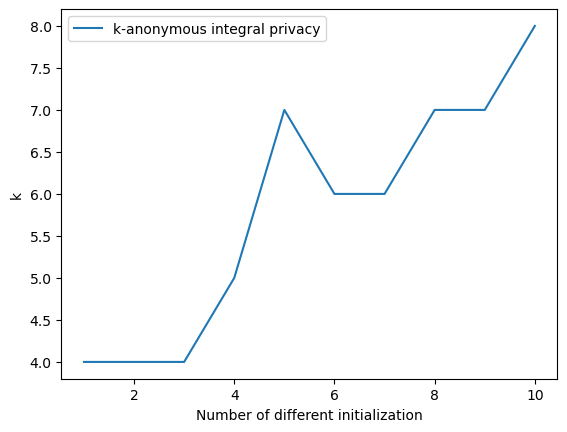

In [71]:
#here's the fig for k-anonymity with increasing initialization parameters
diff_in=[1,2,3,4,5,6,7,8,9,10]
k_anonymous=[4,4,4,5,7,6,6,7,7,8]
plt.xlabel("Number of different initialization")
plt.ylabel("k")
plt.plot(diff_in, k_anonymous, label = "k-anonymous integral privacy")
plt.legend()
plt.savefig("k-anonymous Integral privacy.pdf")

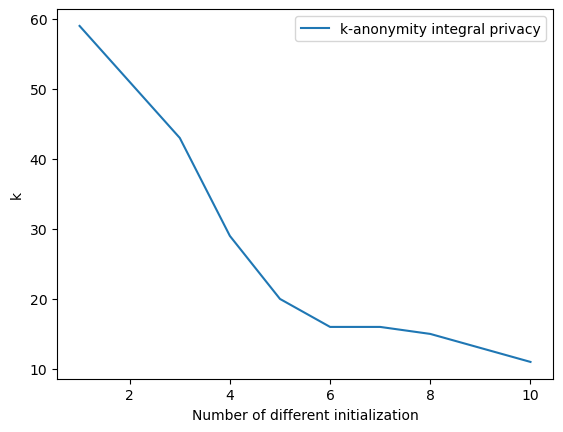

In [72]:
#here's the fig for k-anonymity with increasing initialization parameters
diff_in=[1,2,3,4,5,6,7,8,9,10]
k_anonymity=[59,51,43,29,20,16,16,15,13,11]
plt.xlabel("Number of different initialization")
plt.ylabel("k")
plt.plot(diff_in, k_anonymity, label = "k-anonymity integral privacy")
plt.legend()
plt.savefig("k-anonymity Integral privacy.pdf")

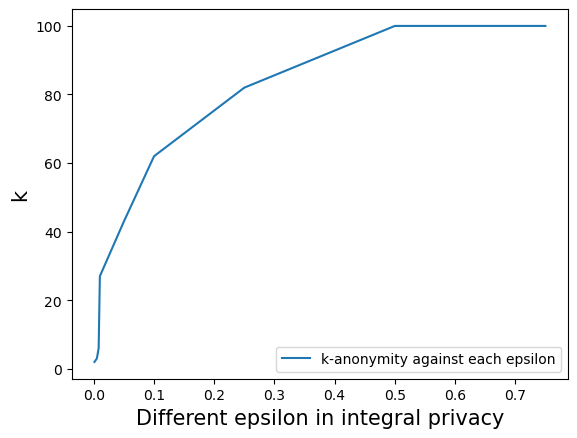

In [82]:
#now increasing epsilon for k-anonymity
epsilon_list=[0.001,0.005,0.008,0.01, 0.05,0.1, 0.25,0.5,0.75]
anonymity_list=[2,3,6,27,43,62,82,100,100]
plt.xlabel("Different epsilon in integral privacy", size="15")
plt.ylabel("k", size="15")
plt.plot(epsilon_list,anonymity_list, label="k-anonymity against each epsilon")
plt.legend()
plt.savefig("k-anonymity against each epsilon.pdf")

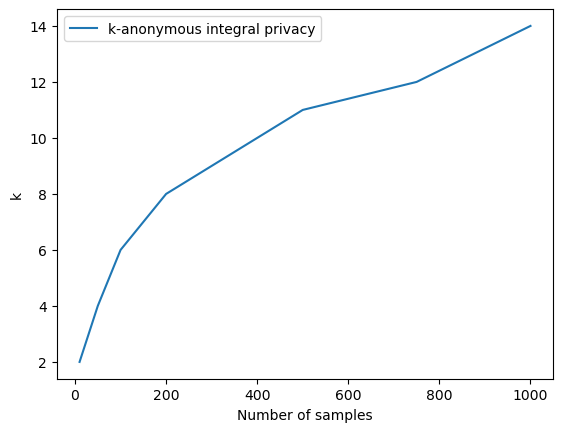

In [77]:
#here's the image for increasing m for k-anonymous IP
num_samples=[10,50,100,200,500,750,1000]
k_anon=[2,4,6,8,11,12,14]
plt.xlabel("Number of samples")
plt.ylabel("k")
plt.plot(num_samples,k_anon, label="k-anonymous integral privacy")
plt.legend()
plt.savefig("k-anonymous IP against number of samples.pdf")

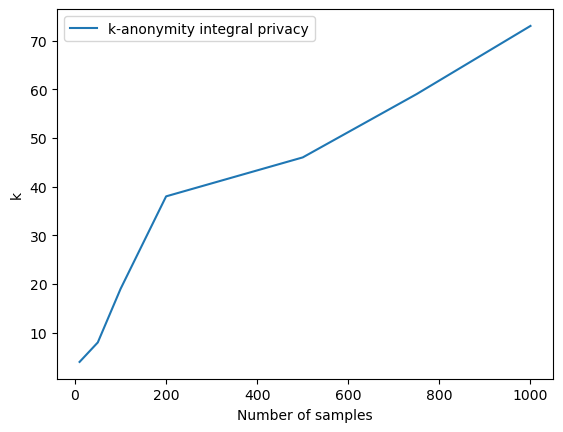

In [83]:
#here's the image for increasing m for k-anonymity IP
num_samples=[10,50,100,200,500,750,1000]
k_anon=[4,8,19,38,46,59,73]
plt.xlabel("Number of samples")
plt.ylabel("k")
plt.plot(num_samples,k_anon, label="k-anonymity integral privacy")
plt.legend()
plt.savefig("k-anonymity IP against number of samples.pdf")

In [2]:
pip install pickle

ERROR: Could not find a version that satisfies the requirement pickel (from versions: none)
ERROR: No matching distribution found for pickel

[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pickle
file = open('posionacc_IP_noniid_0.005_0.01_29_1.p', 'rb')
A=pickle.load(file)
print(A)

[0.0, 0.0, 0.0, 0.0, 0.001762114537444934, 0.001762114537444934, 0.001762114537444934, 0.001762114537444934, 0.001762114537444934, 0.001762114537444934, 0.001762114537444934, 0.001762114537444934, 0.001762114537444934, 0.001762114537444934, 0.001762114537444934, 0.001762114537444934, 0.001762114537444934, 0.001762114537444934, 0.001762114537444934, 0.001762114537444934, 0.001762114537444934, 0.001762114537444934, 0.001762114537444934, 0.001762114537444934, 0.001762114537444934, 0.000881057268722467, 0.000881057268722467, 0.000881057268722467, 0.000881057268722467, 0.000881057268722467]
